### Importing data

In [1]:
import os

#os.getcwd()
os.chdir('..\\tennis_atp')
#os.getcwd()

In [2]:
import re
file = "atp_matches_2017.csv"
int(re.search(r'\d{4}', file).group(0))

2017

In [3]:
lower_limit = 2010

In [4]:
import pandas as pd
import re

files = [file for file in os.listdir() if file.startswith("atp_matches_") and file.endswith(".csv") and "doubles" not in file  and "amateur" not in file and  int(re.search(r'\d{4}', file).group(0)) >= lower_limit]

atp_matches = pd.concat([pd.read_csv(file, sep=",") for file in files])

sorted_columns = sorted(atp_matches.columns, key=lambda x: (x.split('_')[-1], x))

atp_matches = atp_matches[sorted_columns]

atp_matches.tail(5)

,l_1stIn,w_1stIn,l_1stWon,w_1stWon,l_2ndWon,w_2ndWon,l_SvGms,w_SvGms,l_ace,w_ace,...,loser_rank,winner_rank,round,score,loser_seed,winner_seed,draw_size,surface,l_svpt,w_svpt
4518,43.0,31.0,30.0,24.0,13.0,18.0,9.0,10.0,2.0,4.0,...,NaN,511.0,Q1,6-3 6-4,NaN,8,32,Clay,78.0,64.0
4519,41.0,29.0,21.0,25.0,8.0,9.0,9.0,9.0,0.0,5.0,...,NaN,470.0,Q1,7-5 6-0,NaN,5,32,Clay,60.0,44.0
4520,34.0,33.0,26.0,27.0,15.0,13.0,10.0,9.0,4.0,5.0,...,955.0,636.0,Q1,6-4 6-3,NaN,12,32,Clay,72.0,54.0
4521,22.0,32.0,9.0,26.0,4.0,5.0,6.0,7.0,2.0,0.0,...,NaN,487.0,Q1,6-0 6-1,NaN,6,32,Clay,36.0,43.0
4522,28.0,28.0,19.0,22.0,7.0,12.0,9.0,9.0,0.0,10.0,...,880.0,555.0,Q1,7-5 6-0,NaN,NaN,32,Clay,52.0,44.0


Data consists of observations, where each observation represents an ATP tennis match. Both player-characteristics such as age, rank and height are included as well as match level statistics such as 1st serve points won and number of break points saved. A complete list of columns included is shown below: 

- tourney_id: Tournament ID
- tourney_name: Tournament Name
- surface: Surface of the court
- draw_size: Size of the draw
- tourney_level: Level of the tournament
- tourney_date: Date of the tournament
- match_num: Match number
- winner_id: Winner ID
- winner_seed: Winner seed
- winner_entry: Winner entry
- winner_name: Winner name
- winner_hand: Winner hand
- winner_ht: Winner height
- winner_ioc: Winner country
- winner_age: Winner age
- winner_rank: Winner rank
- winner_rank_points: Winner rank points
- loser_id: Loser ID
- loser_seed: Loser seed
- loser_entry: Loser entry
- loser_name: Loser name
- loser_hand: Loser hand
- loser_ht: Loser height
- loser_ioc: Loser country
- loser_age: Loser age
- loser_rank: Loser rank
- loser_rank_points: Loser rank points
- score: Match score
- best_of: Best of
- round: Round
- minutes: Match duration
- w_ace: Winner aces
- w_df: Winner double faults
- w_svpt: Winner service points
- w_1stIn: Winner first serves in
- w_1stWon: Winner first serve points won
- w_2ndWon: Winner second serve points won
- w_SvGms: Winner service games
- w_bpSaved: Winner break points saved
- w_bpFaced: Winner break points faced
- l_ace: Loser aces
- l_df: Loser double faults
- l_svpt: Loser service points
- l_1stIn: Loser first serves in
- l_1stWon: Loser first serve points won
- l_2ndWon: Loser second serve points won
- l_SvGms: Loser service games
- l_bpSaved: Loser break points saved


# Construction of response variable (Main player vs. Other player)

First I define the response variable, which is a discrete variable that can take the values 0 or 1. The value 0 indicates that the main player lost the match, the value 1 indicates that the main player won the match. The main player is chosen as one of the two players by random.

In [5]:

import numpy as np

np.random.seed(42)
atp_matches['Main_player'] = np.where(np.random.binomial(n=1, p=0.5, size=len(atp_matches)) == 1, 'winner', 'loser')

atp_matches['Outcome'] = np.where(atp_matches['Main_player'] == 'winner', 1, 0)

atp_matches['Main_player_name'] = np.where(atp_matches['Main_player'] == 'winner', atp_matches['winner_name'],
                                           atp_matches['loser_name'])

atp_matches['Other_player_name'] = np.where(atp_matches['Main_player'] == 'winner', atp_matches['loser_name'],
                                           atp_matches['winner_name'])

## Mapping round of match to integer

Round robin matches are matches, where each player competes against each other (e.g in a Davis-Cup or Nitto ATP Finals). Since we cannot order such matches based on the data available, we exclude all round robin matches.



In [6]:
atp_matches[atp_matches['round']=='RR']['tourney_name']

642     Davis Cup G1 R1: AUS vs TPE
643     Davis Cup G1 R1: AUS vs TPE
644     Davis Cup G1 R1: AUS vs TPE
645     Davis Cup G1 R1: AUS vs TPE
646     Davis Cup G1 R1: CHN vs UZB
                   ...             
3774         Challenger Tour Finals
3775         Challenger Tour Finals
3776         Challenger Tour Finals
3777         Challenger Tour Finals
3778         Challenger Tour Finals
Name: tourney_name, Length: 4175, dtype: object

In order to calculate evolution of match statistics for each main player, we need to able to introduce a measure of time. Since only the start date of the tournament is given and not the match date, we need to introduce a measure, which can sort the matches chonologically. To do so we can use the round of the match and convert to numerical as follows:

In [7]:

# Define the round mapping dictionary
round_mapping = {
    'RR': -1,
    'BR': 0,
    'R128': 1,
    'R64': 2,
    'R32': 3,
    'R16': 4,
    'QF': 5,
    'SF': 6,
    'F': 7
}

atp_matches['round'] = atp_matches['round'].map(round_mapping)
atp_matches['round'] = atp_matches['round'].fillna(0) #If the round in missing we exclude from 
                                                      #the dataset in order not to mix with other rounds

atp_matches = atp_matches[atp_matches['round']>0]

# Constructing a player database

Now de define a dataset, which lists every match a specific player has played. This data is player-specific, and can be used to calculate time evolution player statistics as well as the evolution of Elo ratings. We then sort the player database by increasing tournament date and increasing round (i.e. most recent matches at bottom of dataframe). Since the pandas rolling function considers observations to the left of the current observation, this sortation of the dataset will result in the desired aggregation of time evolution statistics. 

In [8]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

all_matches_per_player = []

players = atp_matches["Main_player_name"].drop_duplicates()
n = len(players)
index = 1
for player_name in tqdm(players):
    player_matches = atp_matches[(atp_matches["loser_name"]==player_name) 
    | (atp_matches["winner_name"]==player_name)]
    player_matches["player"] = player_name
    player_matches.drop('Main_player_name', axis=1, inplace=True)
    all_matches_per_player.append(player_matches)


all_matches_per_player = pd.concat(all_matches_per_player, ignore_index=True)

all_matches_per_player = all_matches_per_player.sort_values(by=['player', 'tourney_date','round']
                                                            , ascending=[True, True,True])
##


## In future make sure not to rerun but to append most recent matches onto existing csv file. E.g. run for loop where tourney_date > last_stand_point
#through_date = np.max(atp_matches['tourney_date']
#latest_date.append(through_date)
#last_stand_point = np.max(latest_date)

100%|██████████| 10547/10547 [10:43<00:00, 16.39it/s]


We redefine the outcome variable in the player database such that it is player-specific and not Main_player-specific

In [9]:
all_matches_per_player["player_outcome"] = all_matches_per_player.apply(lambda 
row: 1 if row['player']==row['winner_name'] else 0, axis=1).astype(int)


We also extract and assign the corresponding values for age, rank and height.

In [10]:
all_matches_per_player["age"] = all_matches_per_player.apply(lambda 
row: row['winner_age'] if row['player']==row['winner_name'] else row['loser_age'], axis=1)

all_matches_per_player["rank"] = all_matches_per_player.apply(lambda
row: row['winner_rank'] if row['player']==row['winner_name'] else row['loser_rank'], axis=1)

all_matches_per_player["height"] = all_matches_per_player.apply(lambda
row: row['winner_ht'] if row['player']==row['winner_name'] else row['loser_ht'], axis=1)

We can now view a couple of variables from the player database for a specific player (In this case Novak Djokovic), showing the latest recorded matches: 

In [11]:
pd.set_option('display.max_columns', None)
variables = ["tourney_date", "round","player", "player_outcome","age"]
test = all_matches_per_player.loc[all_matches_per_player['player']=='Novak Djokovic',variables]
test.tail(10)


,tourney_date,round,player,player_outcome,age
32509,20240304,3.0,Novak Djokovic,0,36.7
32514,20240408,3.0,Novak Djokovic,1,36.8
32513,20240408,4.0,Novak Djokovic,1,36.8
32512,20240408,5.0,Novak Djokovic,1,36.8
32511,20240408,6.0,Novak Djokovic,0,36.8
32516,20240506,2.0,Novak Djokovic,1,36.9
32515,20240506,3.0,Novak Djokovic,0,36.9
32519,20240520,4.0,Novak Djokovic,1,36.9
32518,20240520,5.0,Novak Djokovic,1,36.9
32517,20240520,6.0,Novak Djokovic,0,36.9


# Head-to-head metric

# Elo rating metric

merge elo rating data from ELO script onto atp_matches (by match date)

# Moving-average metrics


In this section we will construct moving average indicators based on the player database. Once these indicatos have been calcultalted, they can be merged onto atp_matches and thus used to predict win probabilities. 

Note that in the below code sections, we calculate moving averages based on the shifted sum, such that the previous 5/10 matches up to but $\bf{not}$ including the present match is included in the sum. This is to ensure that we do not introduce a functional dependency between the outcome and the moverage-average indicators. The shift operator in Python can be used to address this.

## Construction of historical Win-Loss Ratio 

We now start by defining the historical Win-Loss ratio based on the previous 10 and 5 matches respectively. 


In [12]:
all_matches_per_player['shifted_outcome'] = all_matches_per_player.groupby('player')['player_outcome'].shift(1)
Rolling_wins = all_matches_per_player.groupby('player')['shifted_outcome'].rolling(window=10,min_periods=1).sum().reset_index(level=0, drop=True)
Rolling_wins_5 = all_matches_per_player.groupby('player')['shifted_outcome'].rolling(window=5,min_periods=1).sum().reset_index(level=0, drop=True)


all_matches_per_player['shifted_matches'] = all_matches_per_player['shifted_outcome'].notna()
Rolling_matches = all_matches_per_player.groupby('player')['shifted_matches'].rolling(window=10,min_periods=1).sum().reset_index(level=0, drop=True)
Rolling_matches_5 = all_matches_per_player.groupby('player')['shifted_matches'].rolling(window=5,min_periods=1).sum().reset_index(level=0, drop=True)


# Calculate rolling win-loss ratio and adding match number
all_matches_per_player['Rolling_WLR'] = Rolling_wins / Rolling_matches
all_matches_per_player['Rolling_WLR_5'] = Rolling_wins_5 / Rolling_matches_5
all_matches_per_player['Match_number'] = all_matches_per_player.groupby('player').cumcount() + 1


We can check that the data steps have been carried out as expected by e.g. considering Holger Rune's most recent 15 matches.

In [13]:
all_matches_per_player.loc[all_matches_per_player['player'] == 'Holger Rune', [ 'tourney_date', 'round', 'player', 'player_outcome', 'shifted_outcome', 'shifted_matches','Rolling_WLR', 'Rolling_WLR_5', 'Match_number']].tail(15)

,tourney_date,round,player,player_outcome,shifted_outcome,shifted_matches,Rolling_WLR,Rolling_WLR_5,Match_number
254759,20240304,2.0,Holger Rune,1,0.0,True,0.6,0.6,284
254758,20240304,3.0,Holger Rune,1,1.0,True,0.7,0.8,285
254757,20240304,4.0,Holger Rune,1,1.0,True,0.7,0.8,286
254756,20240304,5.0,Holger Rune,0,1.0,True,0.7,0.8,287
254760,20240318,2.0,Holger Rune,0,0.0,True,0.7,0.6,288
254763,20240408,3.0,Holger Rune,1,0.0,True,0.6,0.6,289
254762,20240408,4.0,Holger Rune,1,1.0,True,0.7,0.6,290
254761,20240408,5.0,Holger Rune,0,1.0,True,0.7,0.6,291
254766,20240415,4.0,Holger Rune,1,0.0,True,0.6,0.4,292
254765,20240415,5.0,Holger Rune,1,1.0,True,0.6,0.6,293


## Construction of historical First Serve Percentage

A strong serve is key to winning matches in tennis. The service player has an advantage as he/she determines the first shot, and a good serve can dictate the rest of the point. A high first serve percentage is often correlated (even causal) with the win probability, and therefore it seems reasonable to account for this effect, via a measure such as the first serve percentage. 


First we define the shifted sum of service points and sum of 1st serves in for each player in the player database.

In [14]:

all_matches_per_player['svpt'] = all_matches_per_player.apply( lambda row: row['w_svpt'] if row['player'] == row['winner_name']
                                                              else  row['l_svpt'], axis=1)

all_matches_per_player['svIn'] = all_matches_per_player.apply( lambda row: row['w_1stIn'] if row['player'] == row['winner_name']
                                                              else  row['l_1stIn'],axis=1)

all_matches_per_player['shifted_svpt'] = all_matches_per_player.groupby('player')['svpt'].shift(1)
all_matches_per_player['shifted_svIn'] = all_matches_per_player.groupby('player')['svIn'].shift(1)


We then calculate the historical First Serve Percentage as the proportion of first service points won. Both 5 and 10 lookback periods are considered. 

In [15]:


all_matches_per_player['Rolling_SVP'] = (all_matches_per_player.groupby('player')['shifted_svIn'].rolling(window=10,
                                                                                          min_periods=1).sum().reset_index(
    level=0, drop=True) /
                             all_matches_per_player.groupby('player')['shifted_svpt'].rolling(window=10,
                                                                                          min_periods=1).sum().reset_index(
                                 level=0, drop=True))

In [16]:

all_matches_per_player['Rolling_SVP_5'] = (all_matches_per_player.groupby('player')['shifted_svIn'].rolling(window=5,
                                                                                          min_periods=1).sum().reset_index(
    level=0, drop=True) /
                             all_matches_per_player.groupby('player')['shifted_svpt'].rolling(window=5,
                                                                                          min_periods=1).sum().reset_index(
                                 level=0, drop=True))

We can check that the data steps have been carried out as expected by e.g. considering Holger Rune's most recent 15 matches.

In [17]:
all_matches_per_player.loc[all_matches_per_player['player'] == 'Holger Rune', [ 'tourney_date', 'round', 'player', 'Rolling_SVP','Rolling_SVP_5','svpt','shifted_svpt','svIn','shifted_svIn','Match_number']].tail(15)

,tourney_date,round,player,Rolling_SVP,Rolling_SVP_5,svpt,shifted_svpt,svIn,shifted_svIn,Match_number
254759,20240304,2.0,Holger Rune,0.582667,0.571429,NaN,82.0,NaN,40.0,284
254758,20240304,3.0,Holger Rune,0.588907,0.565517,59.0,NaN,38.0,NaN,285
254757,20240304,4.0,Holger Rune,0.588907,0.586441,94.0,59.0,53.0,38.0,286
254756,20240304,5.0,Holger Rune,0.582677,0.580952,84.0,94.0,47.0,53.0,287
254760,20240318,2.0,Holger Rune,0.582222,0.557994,41.0,84.0,25.0,47.0,288
254763,20240408,3.0,Holger Rune,0.577953,0.586331,70.0,41.0,38.0,25.0,289
254762,20240408,4.0,Holger Rune,0.572100,0.577586,135.0,70.0,94.0,38.0,290
254761,20240408,5.0,Holger Rune,0.598053,0.606132,95.0,135.0,50.0,94.0,291
254766,20240415,4.0,Holger Rune,0.590541,0.597647,54.0,95.0,28.0,50.0,292
254765,20240415,5.0,Holger Rune,0.578431,0.594937,76.0,54.0,52.0,28.0,293


## Construction of historical Second Serve Win Percentage

A weak first service can be compensated by a strong second serve. Roger Federer did not have the fastest serve, but his placement of the serve and ability to disguise his placement was key to his success. 

In [18]:
all_matches_per_player['ssvWon'] = all_matches_per_player.apply( 
    lambda row: row['w_2ndWon'] if row['player'] == row['winner_name'] else  row['l_2ndWon'],axis=1)

all_matches_per_player['ssvpt'] = all_matches_per_player.apply( 
    lambda row: (row['w_svpt']-row['w_1stIn']-row['w_df']) if row['player'] == row['winner_name']else  row['l_svpt'], axis=1)
    
all_matches_per_player['shifted_ssvpt'] = all_matches_per_player.groupby('player')['ssvpt'].shift(1)
all_matches_per_player['shifted_ssvWon'] = all_matches_per_player.groupby('player')['ssvWon'].shift(1)


In [19]:
all_matches_per_player['Rolling_SSWP'] = (all_matches_per_player.groupby('player')['shifted_ssvWon'].rolling(window=10,
                                                                                          min_periods=1).sum().reset_index(
    level=0, drop=True) /
                             all_matches_per_player.groupby('player')['shifted_ssvpt'].rolling(window=10,
                                                                                          min_periods=1).sum().reset_index(
                                 level=0, drop=True))

all_matches_per_player['Rolling_SSWP_5'] = (all_matches_per_player.groupby('player')['shifted_ssvWon'].rolling(window=5,
                                                                                          min_periods=1).sum().reset_index(
    level=0, drop=True) /
                             all_matches_per_player.groupby('player')['shifted_ssvpt'].rolling(window=5,
                                                                                          min_periods=1).sum().reset_index(
                                 level=0, drop=True))

## Construction of historical Break Points Saved Percentage

In [20]:

all_matches_per_player['bpFaced'] = all_matches_per_player.apply( lambda row: row['w_bpFaced'] if row['player'] == row['winner_name']
                                                              else  row['l_bpFaced'], axis=1)

all_matches_per_player['bpSaved'] = all_matches_per_player.apply( lambda row: row['w_bpSaved'] if row['player'] == row['winner_name']
                                                              else  row['l_bpSaved'],axis=1)

all_matches_per_player['shifted_bpFaced'] = all_matches_per_player.groupby('player')['bpFaced'].shift(1)
all_matches_per_player['shifted_bpSaved'] = all_matches_per_player.groupby('player')['bpSaved'].shift(1)

In [21]:
all_matches_per_player['Rolling_BPS'] = (all_matches_per_player.groupby('player')['shifted_bpSaved'].rolling(window=10,
                                                                                          min_periods=1).sum().reset_index(
    level=0, drop=True) /
                             all_matches_per_player.groupby('player')['shifted_bpFaced'].rolling(window=10,
                                                                                          min_periods=1).sum().reset_index(
                                 level=0, drop=True))

all_matches_per_player['Rolling_BPS_5'] = (all_matches_per_player.groupby('player')['shifted_bpSaved'].rolling(window=5,
                                                                                          min_periods=1).sum().reset_index(
    level=0, drop=True) /
                             all_matches_per_player.groupby('player')['shifted_bpFaced'].rolling(window=5,
                                                                                          min_periods=1).sum().reset_index(
                                 level=0, drop=True))

## Visualization of player specific evolution metrics

We can for example visualize the performance over time of each individual player as follows:



In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evolution(x,y,data, player, t=False):
    # Filter data for the specified player
    df = data[data['Main_player_name'] == player]

    # Plot the scatter points
    sns.scatterplot(x=x, y=y, data=df)

    # Add a loess smoother (regression line)
    sns.regplot(x=x, y=y, data=df, scatter=False, label='Loess Smoother', lowess=True, line_kws={'color': 'red'})


    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.title(f'Evolution of historical {y.split("_")[-1]} for {player}')

    # Show the plot
    plt.show()

    # Optionally, print the first 30 rows if t is True
    if t:
        return pd.DataFrame(df).head(50)


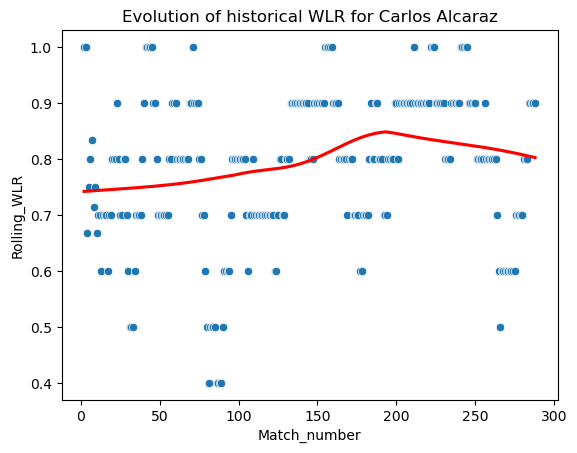

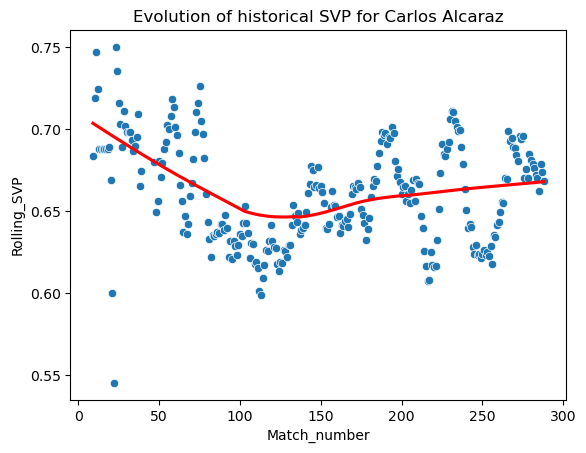

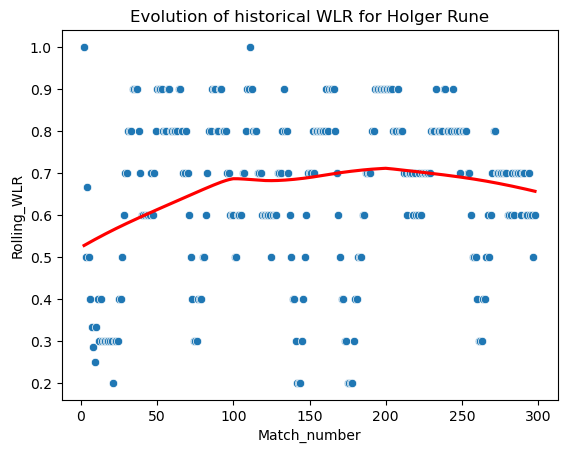

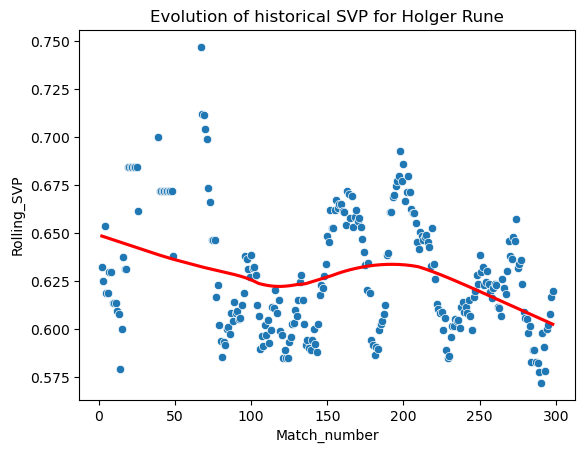

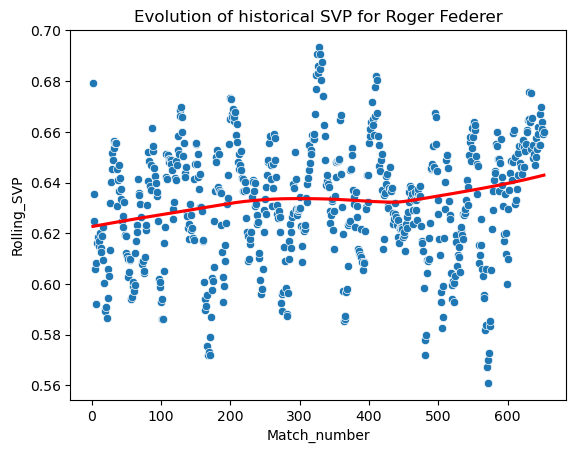

In [23]:
all_matches_per_player.rename(columns={'player': 'Main_player_name'}, inplace=True)
evolution(data = all_matches_per_player, player = 'Carlos Alcaraz',x='Match_number',y='Rolling_WLR')
evolution(data = all_matches_per_player, player = 'Carlos Alcaraz',x='Match_number',y='Rolling_SVP')
evolution(data = all_matches_per_player, player = 'Holger Rune',x='Match_number',y='Rolling_WLR')
evolution(data = all_matches_per_player, player = 'Holger Rune',x='Match_number',y='Rolling_SVP')
evolution(data = all_matches_per_player, player = 'Roger Federer',x='Match_number',y='Rolling_SVP')


We see that Alcaraz has improved his win-loss ratio over time and has had a consistently high WLR during the last 70-80 matches played. 



## Selecting relevant variables from player database for further use

In [24]:
numerical_columns = ['age', 'rank', 'height', 'Rolling_WLR', 'Rolling_WLR_5', 'Rolling_SVP', 'Rolling_SVP_5', 'Rolling_SSWP', 'Rolling_SSWP_5', 'Rolling_BPS', 'Rolling_BPS_5']
categorical_columns = ['Main_player_name','tourney_date','round','draw_size', 'surface', 'tourney_level']
player_data = all_matches_per_player[categorical_columns + numerical_columns]

# Merging moving average indicators onto atp_matches data

Now we will merge the time-evolution indicators onto the match dataset, atp_matches. We merge by a combination of three variables: Round, main/other player name and start date of the tournament. This combination should have the same effect as a unique match id, which we unfortunately don't have, and thus a sufficient key to merge player evolution statistics correctly onto a match in the atp_matches table. 

First we extract the sufficient variables from atp_matches

In [25]:
pd.set_option('display.max_columns', None)
player_data_copy = player_data.copy()

atp_matches_copy = atp_matches.copy()
vars = ['Main_player_name','Other_player_name','Outcome','tourney_name', 'tourney_date','round','surface','draw_size','tourney_level']
atp_matches_copy = atp_matches_copy[vars]

Then we merge the player database onto the atp_matches corresponding to the main player name. Then we do the same but for the other player. This results in _x (main player) and _y (other player) variables.

In [26]:
test = pd.merge(atp_matches_copy,player_data_copy,how="left",on = ["Main_player_name","tourney_date","round"])
test = test.sort_values(by=['Main_player_name', 'tourney_date','round']
                                                           , ascending=[True, True,True])

In [27]:
player_data_copy.rename(columns={'Main_player_name': 'Other_player_name'}, inplace=True)
test2 = pd.merge(test,player_data_copy,how="left",on = ["round","Other_player_name","tourney_date"])
player_data_copy.rename(columns={'Other_player_name' : 'Main_player_name'}, inplace=True)

Then we calculate the difference between the two players for each of the moving average indicators:

In [28]:

test2["age_diff"]=test2["age_x"]-test2["age_y"]
test2["rank_diff"]=test2["rank_x"]-test2["rank_y"]
test2["height_diff"]=test2["height_x"]-test2["height_y"]

test2["Rolling_WLR_diff"]=test2["Rolling_WLR_x"]-test2["Rolling_WLR_y"]
test2["Rolling_WLR_5_diff"]=test2["Rolling_WLR_5_x"]-test2["Rolling_WLR_5_y"]

test2["Rolling_SVP_diff"]=test2["Rolling_SVP_x"]-test2["Rolling_SVP_y"]
test2["Rolling_SVP_5_diff"]=test2["Rolling_SVP_5_x"]-test2["Rolling_SVP_5_y"]

test2["Rolling_SSWP_diff"]=test2["Rolling_SSWP_x"]-test2["Rolling_SSWP_y"]
test2["Rolling_SSWP_5_diff"]=test2["Rolling_SSWP_5_x"]-test2["Rolling_SSWP_5_y"]

test2["Rolling_BPS_diff"]=test2["Rolling_BPS_x"]-test2["Rolling_BPS_y"]
test2["Rolling_BPS_5_diff"]=test2["Rolling_BPS_5_x"]-test2["Rolling_BPS_5_y"]

#test2.sort_values(by=['Main_player_name', 'tourney_date','round']
                                                           #, ascending=[True, True,True])

test2 = test2.filter(regex='^(?!.*(_x|_y)$)')                                                           

# Splitting data into train and test

In [29]:
from sklearn.model_selection import train_test_split
X = test2.copy()
X.drop('Outcome',axis=1, inplace=True)
y = test2['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Saving data for further use

In [30]:

os.chdir('..\\Python\\Temp data')
#os.getcwd()

In [31]:
X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)
X_train.to_csv('X_train.csv', index=False)  
X_test.to_csv('X_test.csv', index=False)  
y_train.to_csv('y_train.csv', index=False)  
y_test.to_csv('y_test.csv', index=False) 
player_data_copy.to_csv('player_data.csv', index=False) 